# Packages & Includes

In [1]:
using Plots
using StatsBase
using LinearAlgebra
using Statistics
using JLD2
using Dates
using LsqFit
using StaticArrays

# data structure module (needs to be module to avoid overwriting local variables in REPL scope)
include("SpinSimParams.jl")
using .SpinSimParams

# function libraries
include("spin_sims.jl");

# Parameters

In [43]:
# interaction
α = 0.13;
ω = 0;

# spin ensemble
nx = 50
ny = 50
nz = 1
nfreq = nx*ny*nz;

# I gave γ, τ, dt, ψ_0, bw, and ν0 default values since we almost never change them at this point

# lattice parameters
# 2D lattice:
hlk = [1; 1];
θ = [π/2];
# 3D lattice:
#hlk = [1; 1; 1];
#θ = [π/2; π/2; π/2];

# wavevectors
#ky = collect(exp10.(LinRange(-1, 1, 10)))
#pushfirst!(ky,0)
ky = [0, 0.01, 0.05, 0.1, 0.5];

k = ();
for i = 1:size(ky,1)
    k = (k..., [0; ky[i]]);
end

# make the parameter file
params = make_params(α, ω, nfreq);

# load lattice parameters
params["hlk"] = hlk;
params["θ"] = θ;
params["k"] = k;

# create lattice
@time r, idx_r = make_lattice(params);
params["r"] = r;

  0.023971 seconds (105.50 k allocations: 3.270 MiB)


# Make stencil

In [44]:
params["local_M_on"] = true;

#ξ_list = [0.1, 0.5, 1, 5, 10, 9999] # correlation length, in units of lattice parameter
ξ_list = [0.1, 0.5, 1, 5, 10, 1e10]
M_stencil_list = []
for ξ in ξ_list
    M_stencil = zeros(nx,ny,nz)

    for a = 1:nx
        for b = 1:ny
            for c = 1:nz
                a_loc = mod(a-1+nx/2,nx) - nx/2
                b_loc = mod(b-1+ny/2,ny) - ny/2
                c_loc = mod(c-1+nz/2,nz) - nz/2

                r_loc = [a_loc, b_loc, c_loc]
                M_stencil[a,b,c] = 1/(norm(r_loc)/ξ+1)

            end
        end
    end

    #M_stencil = M_stencil./sum(M_stencil)  # the vector P is used to normalize instead
    #M_stencil[1,1,1] = 0 # no onsite correlation
    push!(M_stencil_list,M_stencil)
end

params["M_stencil"] = M_stencil_list

# set the variables to loop over
vars = ["k","M_stencil"];
params["vars"] = vars;


# Run the Simulation

In [45]:
I, d = make_idx(vars, params)
M_list = Array{Any}(undef, d)

for i in I

    # generate temporary parameters
    tparams = make_temp_params(params, vars, i)

    # simulate
    @time M_list[i] = spin_echo_sim(tparams)

end

# @save "001_M_list.jld2" M_list
# @save "001_parameters.jld2" params

 33.315262 seconds (188.20 M allocations: 98.138 GiB, 13.75% gc time)
 34.058011 seconds (188.20 M allocations: 98.138 GiB, 12.83% gc time)
 33.657612 seconds (188.20 M allocations: 98.138 GiB, 14.02% gc time)
 34.013361 seconds (188.20 M allocations: 98.138 GiB, 13.02% gc time)
 33.255301 seconds (188.20 M allocations: 98.138 GiB, 13.22% gc time)
 33.351695 seconds (188.20 M allocations: 98.138 GiB, 13.31% gc time)
 33.814150 seconds (188.20 M allocations: 98.138 GiB, 13.96% gc time)
 33.623393 seconds (188.20 M allocations: 98.138 GiB, 13.87% gc time)
 33.689128 seconds (188.20 M allocations: 98.138 GiB, 13.98% gc time)
 33.653445 seconds (188.20 M allocations: 98.138 GiB, 13.89% gc time)
 33.720773 seconds (188.20 M allocations: 98.138 GiB, 13.85% gc time)
 33.662768 seconds (188.20 M allocations: 98.138 GiB, 13.92% gc time)
 34.306989 seconds (188.20 M allocations: 98.138 GiB, 12.16% gc time)
 32.533721 seconds (188.20 M allocations: 98.138 GiB, 12.49% gc time)
 33.662274 seconds (

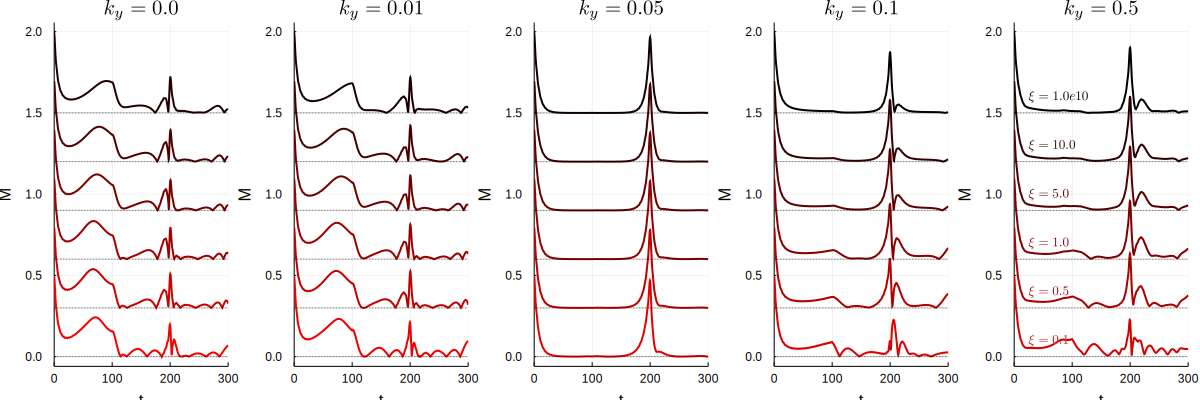

In [ ]:
using LaTeXStrings
using Printf

nξ = length(ξ_list)
nk = length(params["k"])

plt1 = plot(size=(1200,400),layout=(1,nk))


nM = length(M_list)
M_idx = 1

for i in I
    M = M_list[i]
    t = LinRange(0, 300, size(M, 1));
    #y_shift = 0*0.4*(6-var1);
    cidx = (nM-M_idx)/nM
    lc = RGB(cidx,0,0)
    k_y_here = 0
    xi_here = 0
    k_y_h = params["k"][i[1]][2]
    xi_h = ξ_list[i[2]]
    
    y_shift = (i[2]-1)*0.3
    splot_idx = i[1]

    label_h = latexstring("\\xi = ",xi_h);
    plot!(t, y_shift .+ broadcast(abs, M), 
            label="", lw=2,color=lc, legend=:topleft, subplot=splot_idx)
    if (splot_idx == nk)
        annotate!(25,y_shift+.1,text(label_h,:left, 9, color=lc), subplot=splot_idx)
    end
    plot!(t,zeros(size(t)) .+ y_shift, color=RGB(0,0,0), linestyle = :dot, label="", subplot=splot_idx)
    plot!(title=latexstring("k_y = ",k_y_h),subplot=splot_idx)
    M_idx += 1
end
xaxis!("t")
yaxis!("M")
#title!(string(plot_dim,"D, nS = ",nx*ny*nz,raw", \alpha = ",α,raw", \omega = ",ω))
xlims!(0,300)
#ylims!(0,0.5)
display(plt1);




#tparams = temp_parameters(params, vars, I[1])
#params_new = make_parameters(γ, τ, dt, α, ω, ν0, bw, dfreq, ρ0);
#params_new.int_sample = true
#tparams_new = temp_parameters(params_new, vars, I[1])
#histogram(tparams.ν,bins=range(9.75,stop=10.25,length=250))
#plot!(tparams_new.ν,20*lorentzian.(tparams_new.ν,tparams_new.ν0, 0.05))
fname = "ky_and_corr_2d_50x50_integrated";
savefig(plt1,fname)

# Stencil testing area

In [121]:
nx = 4
ny = 4
nz = 1

M_stencil = zeros(nx,ny,nz)
M_stencil[1,1,1] = 1
M_stencil[2,1,1] = 0.5
M_stencil[nx,1,1] = 0.5
M_stencil[1,2,1] = 0.5
M_stencil[1,ny,1] = 0.5



spin_idx = 12

tar_loc_mat = zeros(nx*ny*nz,1)

tar_loc_mat[spin_idx] = 1
tar_loc_mat = reshape(tar_loc_mat, (nx,ny,nz))
target_vec = (findall(x->x==1, tar_loc_mat)[1])
shift_vec = zeros(3)
shift_vec[1] = target_vec[1]-1
shift_vec[2] = target_vec[2]-1
shift_vec[3] = target_vec[3]-1
println(shift_vec )
M_new = circshift(M_stencil, shift_vec)
#reshape(M_new, (nx*ny*nz,1) )



[3.0, 2.0, 0.0]


4×4×1 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.5  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0
 0.0  0.5  1.0  0.5

In [30]:
fprefix = "test_run_06-16-2020"
#@save string(fprefix,"_data.jld2") M_list params
#@save string(fprefix,"_M_list.jld2") M_list
#@save string(fprefix,"_parameters.jld2") params

In [21]:
#@load "test_run_06-16-2020_data.jld2" M_list params
#@load "test_run_06-16-2020_M_list.jld2"
#@load "test_run_06-16-2020_parameters.jld2"
